<a href="https://colab.research.google.com/github/AlejandroSepulvedaGuatecique/Projects-in-Ml-and-AI-/blob/main/HW4/HW4_SequenceModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 4: SEQUENCE MODELS

**USEFUL RESOURCES**

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

## PROJECT DESIGN AND IMPLEMENTATION

The objective of this project is to develop a Recurrent Neural Network (RNN) that is able to predic the future temperature based on a previous temperature time series. The data set is provided by the [Australian Government Bureau of Meteorology](http://www.bom.gov.au/climate/data/). A 10-year history data set is used for this problem, the data set is available in [Kaggle](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package). 

In [1]:
from tensorflow import keras 
from keras.models import Sequential
from keras import Input 
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed, GRU, SimpleRNN

import pandas as pd
import numpy as np 

import sklearn
from sklearn.preprocessing import MinMaxScaler 

import plotly 
import plotly.express as px
import plotly.graph_objects as go

## EXPLORATORY DATA ANALYSIS

The data will be pre-processed. The data set provides the maximum and minimum daily temperature for different locations in Australia. Usually this type of data set presents missing values which will be removed. 

In [2]:
pd.options.display.max_columns=150

# Reading the data
df=pd.read_csv('weatherAUS.csv', encoding='utf-8', usecols=['Date', 'Location', 'MinTemp', 'MaxTemp'])

# Drop NaN measurements
df=df[pd.isnull(df['MinTemp'])==False]
df=df[pd.isnull(df['MaxTemp'])==False]

In [3]:
df2=df[['Location', 'Date', 'MaxTemp','MinTemp']].copy()

df2_minT=df2.pivot(index=['Location'], columns='Date')['MinTemp']

fig = go.Figure()
for location in df2_minT.index:
    fig.add_trace(go.Scatter(x=df2_minT.loc[location, :].index, 
                             y=df2_minT.loc[location, :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))
    
# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Date',
                   yaxis_title='Min Temperature (degrees C)')
fig.show()

The data set presents daily records of minimum and maximum temperatures for different zones in Australia. In the plot above it is clear that each zone has a characteristic weather, therefore for this project the Canberra zone will be analyzed. 

In [4]:
# Create a copy of an original dataframe
df2=df[['Location', 'Date', 'MaxTemp','MinTemp']].copy()

df2_minT=df2.pivot(index=['Location'], columns='Date')['MinTemp']
df2_maxT=df2.pivot(index=['Location'], columns='Date')['MaxTemp']
location = 'Canberra'
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2_minT.loc[location, :].index, 
                         y=df2_minT.loc[location, :].values,
                         mode='lines',
                         name=location,
                         opacity=0.8,
                         line=dict(width=1)
                        ))
fig.add_trace(go.Scatter(x=df2_maxT.loc[location, :].index, 
                         y=df2_maxT.loc[location, :].values,
                         mode='lines',
                         name=location,
                         opacity=0.8,
                         line=dict(width=1)
                        ))
# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Date',
                   yaxis_title='Temperature (degrees C)')
fig.show()

The previous plot shows the minimum and maximum temperatures in Canberra from 2008 to 2017. However, the objective of this project is to obtain a mean average temperature, therefore a new feature will be computed as the average temperature between the min and max temperature records. 

In [5]:
# Average daily temperature
df['MedTemp']=df[['MinTemp', 'MaxTemp']].median(axis=1)

# Selecting key parameters
df_days=df[['Location', 'Date', 'MedTemp']].copy()

# Selecting data from Canberra
df_Canberra_days = df_days[df_days.Location=='Canberra'].copy()

# Transposing the data
df_Canberra_days_pivot=df_Canberra_days.pivot(index=['Location'], columns='Date')['MedTemp']

In [6]:
# Plot average monthly temperature derived from daily medians for each location
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Canberra_days_pivot.loc['Canberra', :].index, 
                             y=df_Canberra_days_pivot.loc['Canberra', :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))
# Set figure title
fig.update_layout(title=dict(text="Average Daily Temperatures", font=dict(color='black')))

fig.show()

Unfortunately the daily average temperature fluctuates significantly. These fluctuactions can be considered as noise since we are looking for the average estimation of the temperature. The analysis will be done in a average monthly basis. The average temperature for each month will be computed. 

In [7]:
df_months=df[['Location', 'Date', 'MedTemp']].copy()
df_months['Year-Month']= (pd.to_datetime(df_months['Date'], yearfirst=True)).dt.strftime('%Y-%m')

# Canberra data
df_Canberra_months = df_months[df_months.Location=='Canberra'].copy()

# Monthly average temperature
df_Canberra_months=df_Canberra_months.groupby(['Location', 'Year-Month'], as_index=False).mean()

# Transpose dataframe 
df_Canberra_months_pivot=df_Canberra_months.pivot(index=['Location'], columns='Year-Month')['MedTemp']

In [8]:
# Plot average monthly temperature derived from daily medians for each location
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_Canberra_months_pivot.loc['Canberra', :].index, 
                             y=df_Canberra_months_pivot.loc['Canberra', :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))
# Set figure title
fig.update_layout(title=dict(text="Average Monthly Temperatures", font=dict(color='black')))

fig.show()

The fluctuations associated with the daily temperatures were removed from the data. An average temperature for each month was computed. We have a monthly temperature history from November 2007 to June 2017 for the Zone of Canberra in Australia. 

In [9]:
print(min(list(df_Canberra_months_pivot)))
print(max(list(df_Canberra_months_pivot)))

2007-11
2017-06


The predictions for this project are many-to-many. The input data will be a sequence of 14 monthly temperatures, while the output data data will be the temperature for the next 14 months. 
The data set will be splitted into train, validation and test data set. 

In [10]:
timestep=14

# Splitting data into train, validation and test data set
df_test=df_Canberra_months_pivot.iloc[:, -2*timestep:].copy()
df_val=df_Canberra_months_pivot.iloc[:, -4*timestep:-2*timestep].copy()
df_train=df_Canberra_months_pivot.iloc[:, 0:-4*timestep].copy()

print(df_Canberra_months_pivot.shape)
print(df_test.shape)
print(df_val.shape)
print(df_train.shape)

(1, 113)
(1, 28)
(1, 28)
(1, 57)


In this project, the RNNs will be implemented using the TensorFlow (TF) framework. In TF the shape of the input data is given as n_samples x timesteps x n_features. In our case, the number of features is 1. Our data set has a different shape, therefore a shaper function is written to transform our data set to the right shape. 

In [11]:
def shaper(data, ts):
    n_samples = len(np.arange(0, len(data.columns)-(2*ts)+1))
    arr = data.to_numpy().flatten()
    i = 0
    X_start = i 
    X_end = i + ts
    Y_start = i + ts
    Y_end = i + 2*ts
    X_con = arr[X_start:X_end]
    Y_con = arr[Y_start:Y_end]

    for i in range(1, len(data.columns)-(2*ts)+1):   # It ensures that the last iteration will have enough data to create the time series

      X_start = i 
      X_end = i + ts
      Y_start = i + ts
      Y_end = i + 2*ts
      
      X_con = np.append(X_con, arr[X_start:X_end])
      Y_con = np.append(Y_con, arr[Y_start:Y_end])

    # Reshape input and target arrays
    X_RNN=np.reshape(X_con, (n_samples, timestep, 1))
    Y_RNN=np.reshape(Y_con, (n_samples, timestep, 1))
    return X_RNN, Y_RNN

The train, validation and test data sets are reshaped into the correct fashion. 

In [12]:
X_test, Y_test = shaper(data=df_test, ts=timestep)
X_val, Y_val = shaper(data=df_val, ts=timestep)
X_train, Y_train = shaper(data=df_train, ts=timestep)

## SIMPLE RNN

A simple RNN will be implemented in this step. The cell in this case is based on a simple Neural layer with a tanh activation function. A first layer is defined just to specify the input shape to the sequential model. Then, a bidirectional simple RNN is stated with 32 units and tanh activation function. Finally, a dense layer is applied with linear activation function. The purpose of this final layer is to match the output size shape with the input shape. The optimizer algorithm is adam, the loss function is the mean squared error and the metric is the maximum absolute error (MAE). 

In [20]:
model_RNN = Sequential(name="RNN-GRU") 
model_RNN.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_RNN.add(Bidirectional(SimpleRNN(units=32, activation='tanh', stateful=False, return_sequences=True), name='GRU')) 
model_RNN.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model_RNN.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history = model_RNN.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=1000, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [24]:
# list all data in history
print(history.history.keys())
LOSS_t = history.history['loss']
LOSS_v = history.history['val_loss']
ACC_t = history.history['MAE']
ACC_v = history.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


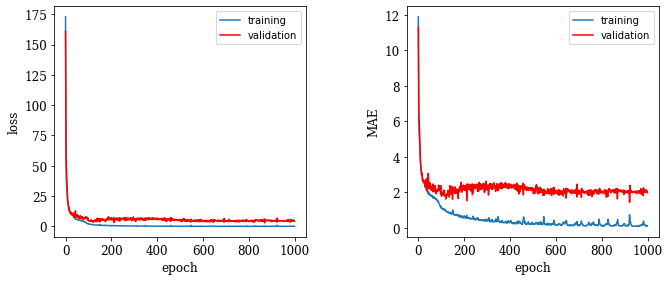

In [25]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(LOSS_t,'-', label = 'training')
axes[0].plot(LOSS_v,'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(ACC_t,'-', label = 'training')
axes[1].plot(ACC_v,'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('MAE',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

In [30]:
print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[200])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[200])

print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[180])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[180])

print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[150])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[150])

MAE of the validation set at 200 epochs: 2.16
loss of the validation set at 200 epochs: 5.46
MAE of the validation set at 200 epochs: 2.08
loss of the validation set at 200 epochs: 5.34
MAE of the validation set at 200 epochs: 1.85
loss of the validation set at 200 epochs: 4.11


It can be seen that after 150 epochs the MAE and loss of the validation set do not decrease anymore. Increasing the number of epochs beyond this threshold may lead to overfitting issue. Therefore, the number of epochs is set to 150. 

## NUMBER OF NODES EFFECTS

In the following step the **number of nodes** of the neural network will be assessed. The number of nodes considered will be 14 as the time steps of the input data, 32 nodes and finally 64. 

In [31]:
model_RNN = Sequential(name="RNN") 
model_RNN.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_RNN.add(Bidirectional(SimpleRNN(units=14, activation='tanh', stateful=False, return_sequences=True), name='GRU')) 
model_RNN.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model_RNN.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history = model_RNN.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=200, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [32]:
# list all data in history
print(history.history.keys())
LOSS_t = history.history['loss']
LOSS_v = history.history['val_loss']
ACC_t = history.history['MAE']
ACC_v = history.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


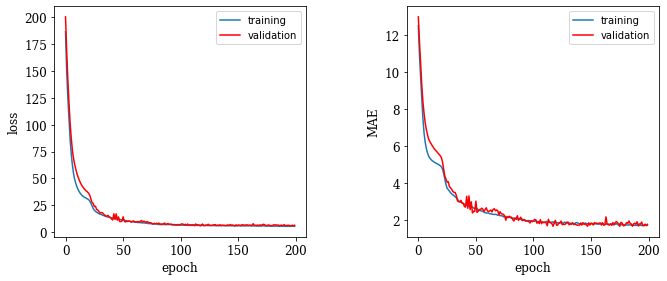

In [33]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(LOSS_t,'-', label = 'training')
axes[0].plot(LOSS_v,'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(ACC_t,'-', label = 'training')
axes[1].plot(ACC_v,'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('MAE',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

In [34]:
print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[149])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[149])

MAE of the validation set at 200 epochs: 1.72
loss of the validation set at 200 epochs: 6.21


**64 NUMBER OF NODES:** In the following step the number of nodes of the neural network will be 64.

In [35]:
model_RNN = Sequential(name="RNN") 
model_RNN.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_RNN.add(Bidirectional(SimpleRNN(units=64, activation='tanh', stateful=False, return_sequences=True), name='GRU')) 
model_RNN.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model_RNN.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history = model_RNN.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=200, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [36]:
# list all data in history
print(history.history.keys())
LOSS_t = history.history['loss']
LOSS_v = history.history['val_loss']
ACC_t = history.history['MAE']
ACC_v = history.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


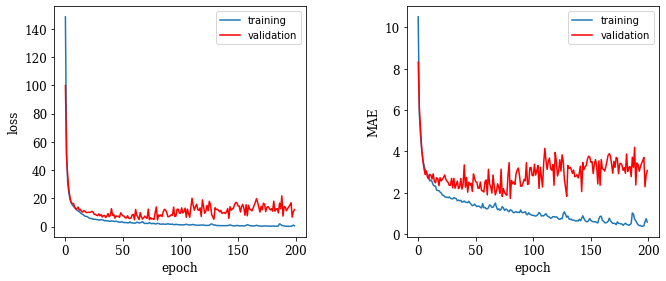

In [37]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(LOSS_t,'-', label = 'training')
axes[0].plot(LOSS_v,'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(ACC_t,'-', label = 'training')
axes[1].plot(ACC_v,'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('MAE',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

In [38]:
print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[149])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[149])

MAE of the validation set at 200 epochs: 3.72
loss of the validation set at 200 epochs:16.79


Number of nodes  | Loss | MAE            
-----------------|------|-----
14               | 6.21 | 1.72 
32               | 4.11 | 1.85  
64               | 16.8 | 3.72

It can be seen that 14 number of nodes may not capture the trend of the time series, however 64 nodes may overkill the complexity problem. **The best results are found with 32 number of nodes**

## BEST SIMPLE RNN MODEL

In [40]:
model_RNN = Sequential(name="RNN-GRU") 
model_RNN.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_RNN.add(Bidirectional(SimpleRNN(units=32, activation='tanh', stateful=False, return_sequences=True), name='GRU')) 
model_RNN.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model_RNN.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history = model_RNN.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=150, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [41]:
# list all data in history
print(history.history.keys())
LOSS_t = history.history['loss']
LOSS_v = history.history['val_loss']
ACC_t = history.history['MAE']
ACC_v = history.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


In [43]:
print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[149])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[149])

MAE of the validation set at 200 epochs: 1.77
loss of the validation set at 200 epochs: 4.47


Lets evaluate the model on the validation data set:

In [44]:
# Predict results on validation data
pred_val = model_RNN.predict(X_val)

1/1 [==============================] - 0s 286ms/step


In [45]:

# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
fig.add_trace(go.Scatter(x=np.array(df_val.columns),
                         y=np.array(df_val.values).flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Actual (Test)',
                         opacity=0.8,
                         line=dict(color='black', width=1)
                        ))

# Trace for predicted temperatures
fig.add_trace(go.Scatter(x=np.array(df_val.columns[-timestep:]),
                         y=pred_val.flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Predicted (Test)',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Month-Year',
                   yaxis_title='Temperature (degrees C)')

The MAE of the validation set is 1.8. The general trend is grasp for the RNN however, the error for first two timesteps predictions deviate significantly from the trend. 

Lets evaluate the model on the test data set

In [46]:
# Predict results on validation data
pred_test = model_RNN.predict(X_test)

1/1 [==============================] - 0s 19ms/step


In [47]:

# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
fig.add_trace(go.Scatter(x=np.array(df_test.columns),
                         y=np.array(df_test.values).flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Actual (Test)',
                         opacity=0.8,
                         line=dict(color='black', width=1)
                        ))

# Trace for predicted temperatures
fig.add_trace(go.Scatter(x=np.array(df_test.columns[-timestep:]),
                         y=pred_test.flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Predicted (Test)',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Month-Year',
                   yaxis_title='Temperature (degrees C)')

In [49]:
from sklearn.metrics import mean_absolute_error
A=np.array(df_test.values).flatten()
MAE = mean_absolute_error(A[14:28],pred_test.flatten())

print('MAE of the test data set%5.1f'%MAE)

MAE of the test data set  2.1


Number of nodes  | Val | Test            
-----------------|-----|----- 
32               | 1.8 | 2.1

Finally the MAE metric obtained with the validations set is equal to 1.8 while with the test set was 2.1. The figures show that trend was correctly model for the RNN however there is still some differences in amplitudes. 

## PART 2

## GATED RECURRENT UNIT

In this section the Gated Recurrent Unit (GRU) will be implemented. The cell in this case is based on a reset gate and update gate with sigmoid activation functions and a simple Neural layer containing the cell state with a tanh activation function. A first layer is defined just to specify the input shape to the sequential model. Then, the bidirectional GRU is stated with 32 units. Finally, a dense layer is applied with linear activation function. The purpose of this final layer is to match the output size shape with the input shape. The optimizer algorithm is adam, the loss function is the mean squared error and the metric is the maximum absolute error (MAE).  

In [50]:
model_GRU = Sequential(name="RNN-GRU") 
model_GRU.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_GRU.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='GRU')) 
model_GRU.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model_GRU.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history_GRU = model_GRU.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=200, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [53]:
# list all data in history
print(history_GRU.history.keys())
LOSS_t = history_GRU.history['loss']
LOSS_v = history_GRU.history['val_loss']
ACC_t = history_GRU.history['MAE']
ACC_v = history_GRU.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


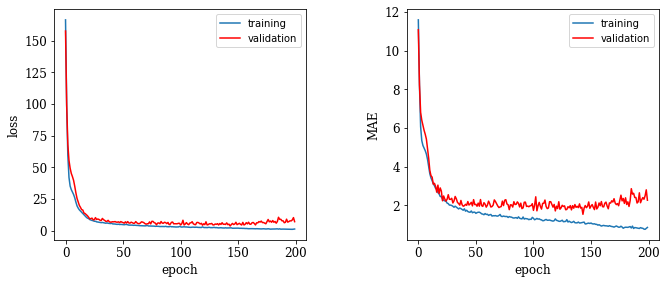

In [54]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(LOSS_t,'-', label = 'training')
axes[0].plot(LOSS_v,'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(ACC_t,'-', label = 'training')
axes[1].plot(ACC_v,'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('MAE',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

In [56]:
print('MAE of the validation set at 200 epochs:%5.2f' %ACC_v[199])
print('loss of the validation set at 200 epochs:%5.2f' %LOSS_v[199])

print('MAE of the validation set at 100 epochs:%5.2f' %ACC_v[100])
print('loss of the validation set at 100 epochs:%5.2f' %LOSS_v[100])

print('MAE of the validation set at 50 epochs:%5.2f' %ACC_v[50])
print('loss of the validation set at 50 epochs:%5.2f' %LOSS_v[50])

MAE of the validation set at 200 epochs: 2.27
loss of the validation set at 200 epochs: 7.03
MAE of the validation set at 100 epochs: 1.74
loss of the validation set at 100 epochs: 4.41
MAE of the validation set at 50 epochs: 2.05
loss of the validation set at 50 epochs: 6.27


The plot above shows the loss and MAE metric change with the number of epochs. It can be seen how the MAE metric decreased at the beginning, but after about 100 epochs the metric starts settling in a constant value or even increasing. This is a clear sign of overfitting. The number of epochs will be defined as 100 for this case. 

In [57]:
model_GRU = Sequential(name="RNN-GRU") 
model_GRU.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_GRU.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='GRU')) 
model_GRU.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model_GRU.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history_GRU = model_GRU.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=100, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

Lets evaluate the model on the validation data set

In [58]:
# Predict results on validation data
pred_val = model_GRU.predict(X_val)

1/1 [==============================] - 1s 757ms/step


In [59]:

# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
fig.add_trace(go.Scatter(x=np.array(df_val.columns),
                         y=np.array(df_val.values).flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Actual (Test)',
                         opacity=0.8,
                         line=dict(color='black', width=1)
                        ))

# Trace for predicted temperatures
fig.add_trace(go.Scatter(x=np.array(df_val.columns[-timestep:]),
                         y=pred_val.flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Predicted (Test)',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Month-Year',
                   yaxis_title='Temperature (degrees C)')

The MAE of the validation set at 100 epochs: 1.7

In [60]:
# Predict results on validation data
pred_test = model_GRU.predict(X_test)

1/1 [==============================] - 0s 19ms/step


In [61]:

# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
fig.add_trace(go.Scatter(x=np.array(df_test.columns),
                         y=np.array(df_test.values).flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Actual (Test)',
                         opacity=0.8,
                         line=dict(color='black', width=1)
                        ))

# Trace for predicted temperatures
fig.add_trace(go.Scatter(x=np.array(df_test.columns[-timestep:]),
                         y=pred_test.flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Predicted (Test)',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Month-Year',
                   yaxis_title='Temperature (degrees C)')

In [62]:
from sklearn.metrics import mean_absolute_error
A=np.array(df_test.values).flatten()
MAE = mean_absolute_error(A[14:28],pred_test.flatten())

print('MAE of the test data set%5.2f'%MAE)

MAE of the test data set 1.92


Number of nodes  | Val | Test            
-----------------|-----|----- 
32               | 1.7 | 1.9


Finally the MAE metric obtained with the validations set is equal to 1.7 while with the test set was 1.9. The figures show that trend was correctly model for the RNN and the performance was improved with respect to the results obtained using the simple RNN.

## LSTM

In this section the Gated Recurrent Unit (GRU) will be implemented. The cell in this case is based on a reset gate and update gate with sigmoid activation functions and a simple Neural layer containing the cell state with a tanh activation function. A first layer is defined just to specify the input shape to the sequential model. Then, the bidirectional GRU is stated with 32 units. Finally, a dense layer is applied with linear activation function. The purpose of this final layer is to match the output size shape with the input shape. The optimizer algorithm is adam, the loss function is the mean squared error and the metric is the maximum absolute error (MAE).  

In [110]:
model_LSTM = Sequential(name="RNN-LSTM") # Model
model_LSTM.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Specifying the input shape
model_LSTM.add(Bidirectional(LSTM(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='LSTM')) # Encoder Layer
model_LSTM.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [111]:
model_LSTM.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history_LSTM = model_LSTM.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=200, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [112]:
# list all data in history
print(history_LSTM.history.keys())
LOSS_t = history_LSTM.history['loss']
LOSS_v = history_LSTM.history['val_loss']
ACC_t = history_LSTM.history['MAE']
ACC_v = history_LSTM.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


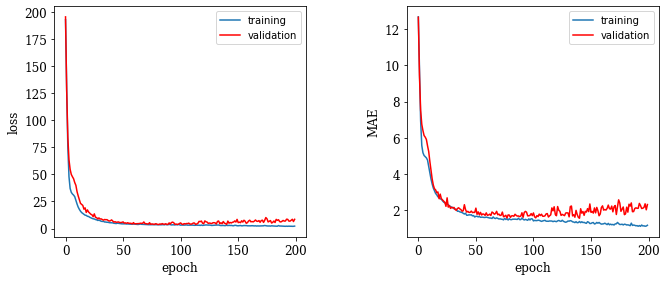

In [113]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(LOSS_t,'-', label = 'training')
axes[0].plot(LOSS_v,'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(ACC_t,'-', label = 'training')
axes[1].plot(ACC_v,'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('MAE',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

In [114]:
print('MAE of the validation set at 200 epochs:%5.1f' %ACC_v[199])
print('loss of the validation set at 200 epochs:%5.1f' %LOSS_v[199])

print('MAE of the validation set at 100 epochs:%5.1f' %ACC_v[100])
print('loss of the validation set at 100 epochs:%5.1f' %LOSS_v[100])

print('MAE of the validation set at 50 epochs:%5.1f' %ACC_v[40])
print('loss of the validation set at 50 epochs:%5.1f' %LOSS_v[40])

MAE of the validation set at 200 epochs:  2.3
loss of the validation set at 200 epochs:  8.5
MAE of the validation set at 100 epochs:  1.9
loss of the validation set at 100 epochs:  5.2
MAE of the validation set at 50 epochs:  2.3
loss of the validation set at 50 epochs:  8.0


The plot above shows the loss and MAE metric change with the number of epochs. It can be seen how the MAE metric decreased at the beginning, but after about 100 epochs the metric starts settling in a constant value or even increasing. This is a clear sign of overfitting. The number of epochs will be defined as 100 for this case. 

In [115]:
model_LSTM.compile(optimizer='adam',
              loss='mean_squared_error', # Loss function to be optimized
              metrics=['MSE', 'MAE'],  
               )

history_LSTM = model_LSTM.fit(X_train, 
                    Y_train, 
                    batch_size=1, 
                    epochs=100, 
                    verbose=0, 
                    validation_data=(X_val, Y_val), 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    use_multiprocessing=True,
                   )

In [119]:
# list all data in history
print(history_LSTM.history.keys())
LOSS_t = history_LSTM.history['loss']
LOSS_v = history_LSTM.history['val_loss']
ACC_t = history_LSTM.history['MAE']
ACC_v = history_LSTM.history['val_MAE']

dict_keys(['loss', 'MSE', 'MAE', 'val_loss', 'val_MSE', 'val_MAE'])


In [120]:
# Predict results on validation data
pred_val = model_LSTM.predict(X_val)

1/1 [==============================] - 0s 18ms/step


In [121]:

# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
fig.add_trace(go.Scatter(x=np.array(df_val.columns),
                         y=np.array(df_val.values).flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Actual (Test)',
                         opacity=0.8,
                         line=dict(color='black', width=1)
                        ))

# Trace for predicted temperatures
fig.add_trace(go.Scatter(x=np.array(df_val.columns[-timestep:]),
                         y=pred_val.flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Predicted (Test)',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Month-Year',
                   yaxis_title='Temperature (degrees C)')

In [122]:
# Predict results on validation data
pred_test = model_LSTM.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [123]:

# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
fig.add_trace(go.Scatter(x=np.array(df_test.columns),
                         y=np.array(df_test.values).flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Actual (Test)',
                         opacity=0.8,
                         line=dict(color='black', width=1)
                        ))

# Trace for predicted temperatures
fig.add_trace(go.Scatter(x=np.array(df_test.columns[-timestep:]),
                         y=pred_test.flatten(),
                         mode='lines+markers',
                         name='Average Monthly Temperatures - Predicted (Test)',
                         opacity=0.8,
                         line=dict(color='red', width=1)
                        ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'),
                   xaxis_title='Month-Year',
                   yaxis_title='Temperature (degrees C)')

In [125]:
from sklearn.metrics import mean_absolute_error
A=np.array(df_test.values).flatten()
MAE = mean_absolute_error(A[14:28],pred_test.flatten())

print('MAE of the test data set%5.1f'%MAE)

MAE of the test data set  1.9


Number of nodes  | Val | Test            
-----------------|-----|----- 
32               | 1.9 | 1.9


Finally the MAE metric obtained with the validations and test set is equal to 1.9. The figures show that trend was correctly model for the LSTM cell and the performance was improved with respect to the results obtained using the simple RNN.

## COMPARISON OF THE THREE MODELS

Method  | Val | Test            
-----------------|-----|----- 
Simple RNN               | 1.8 | 2.1
GRU             | 1.7 | 1.9
LSTM               | 1.9 | 1.9

The GRU and LSTM cells showed to improve the simple RNN model. In this project a timestep equal to 14 was used. The main drawback of Simple RNN is the short memory and vanishing gradient isues. This problem is handled with the GRU and LSTM cells. The GRU and LSTM cells are able to store the trend behavior of the model for a longer timesteps compared with the simple RNN. The simple RNN can perform correctly when small time steps are evaluated, however when the number of time steps increase, then the model is not able to correctly capture the trend. The GRU and LSTM obtained good results and no major difference can be seen between the two model results. However the GRU were able to reduce slightly better the error and predict the response with a minor higher accuracy with respect to the LSTM model. 

## PART 3



Can you use the traditional feed-forward network to solve the same 
problem. Why or why not?

The traditional feed forward network can not be used when the trend depends on what happened on previous steps. The feed forward network do not have information from previous steps, therefore it can not contextualize the trend based on the previous responses. Time series can be converted to usual features and be used as input to a feed-forward network, however, it does not mean that the feed-forward network will predict with high accuracy the response. Basically, since it has no "memory", it will predict poorly the trend. The feed-forward neural network can capture just behavior that it is not dependent on time steps. 

## TASK 2

For this task the [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embedding by Stanford will be used to represent words as vectors. The disimilarity will be assessed using cosine similarity and the euclidian distance. Both metrics are described in this work. 

## COSINE SIMILARITY

The cosine similarity measures the similarity between two vectors of an inner product space. It is measure by the cosine of the angle between two vectors and determines weather two vectors are pointing in roughly the same direction. Mathematically, it is defined as the division between the dot product of vectors and the product of the euclidean norms or magnitude of each vector. 

## EUCLIDEAN DISTANCE

The euclidean distance between two points is the length of a line segment between the two points. Mathematically, the euclidean distance is computed as the squared root of the sum of the squared differences. In the cartesian space this equation provides the length of the line segment between the two points. [link](https://en.wikipedia.org/wiki/Euclidean_distance)

**USEFUL RESOURCES**

https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/

https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a

https://en.wikipedia.org/wiki/Cosine_similarity

https://www.sciencedirect.com/topics/computer-science/cosine-similarity#:~:text=2.4.&text=Cosine%20similarity%20measures%20the%20similarity,document%20similarity%20in%20text%20analysis.

https://intellica-ai.medium.com/comparison-of-different-word-embeddings-on-text-similarity-a-use-case-in-nlp-e83e08469c1c#:~:text=Text%20Similarity%20is%20one%20of,perform%20any%20machine%20learning%20task.

Lets download the pretrained word embedding GloVe by Stanford

In [ ]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-10-22 18:50:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-22 18:50:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-22 18:50:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [ ]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [ ]:
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Lets define a function that obtained the vector representation of two words and computes the cosine simmilarity and euclidean distance of the two words.

In [ ]:
 def similarity_word(word1,word2): 
  A = embeddings_index.get(word1)
  B = embeddings_index.get(word2)
  from numpy import dot
  from numpy.linalg import norm

  cos_sim = dot(A, B)/(norm(A)*norm(B))
  eu_dist = np.linalg.norm(A - B)
  print('Cosine similarity %5.1f' %cos_sim)
  print('Euclidean distance %5.1f' %eu_dist)
  return cos_sim,eu_dist

In [ ]:
word1 = 'shop'
word2 = 'market'
cos_sim,eu_dist = similarity_word(word1,word2) 

Cosine similarity   0.5
Euclidean distance   6.2


The word shop and market were used in the previous example, it is expected that these two words are correlated. The metrics obtained were 0.5 for Cosine similarity and 6.2 for Euclidean distance. Lets try with another pair that may be highly unrelated as shop and albany. 

In [ ]:
word1 = 'shop'
word2 = 'albany'
cos_sim,eu_dist = similarity_word(word1,word2) 

Cosine similarity   0.2
Euclidean distance   6.3


As expected the cosine similarity between shop and albany decreased from 0.5 to 0.2, also, the euclidean distance increased from 6.2 to 6.3. Both metrics help to assess the similarity between two vector representations of words. The cosine similarity compute the angle between both vectors, if the angle is the same the cosine similarity will input a unity value. The cosine similarity is bound between 0 and 1. The euclidean distance, on the other hand, computes the distance between both vectors, if the words are identical the distance is 0 and it increases as the words are less correlated between them. 